In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
# Loading data
train = pd.read_csv("train.csv")
features = pd.read_csv("features.csv")
stores = pd.read_csv("stores.csv")

print(train.shape)
print(features.shape)
print(stores.shape)


(421570, 5)
(8190, 12)
(45, 3)


In [3]:
print(train.columns)

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')


In [4]:
print(features.columns.tolist())

['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday']


In [5]:
print(stores.columns)

Index(['Store', 'Type', 'Size'], dtype='object')


In [6]:
# Merge train with stores
train = pd.merge(train, stores, on="Store", how="left")

# Merge train with features
train = pd.merge(train, features, on=["Store", "Date", "IsHoliday"], how="left")


In [36]:
print(train.columns)

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Size',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'WeekOfYear', 'Month',
       'Year', 'Prev_Week_Sales', 'Rolling_Mean_4', 'Type_B', 'Type_C'],
      dtype='object')


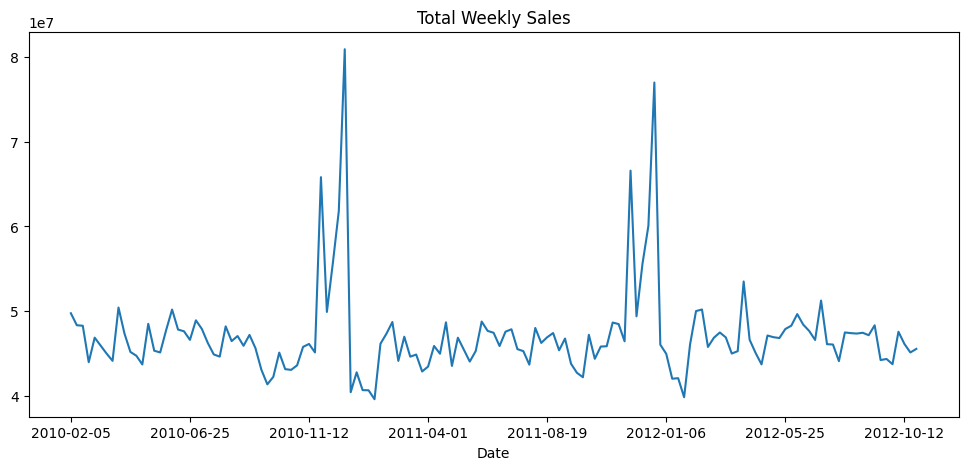

In [7]:
total_sales=train.groupby("Date")["Weekly_Sales"].sum()
total_sales.plot(figsize=(12,5),title="Total Weekly Sales")
plt.show()

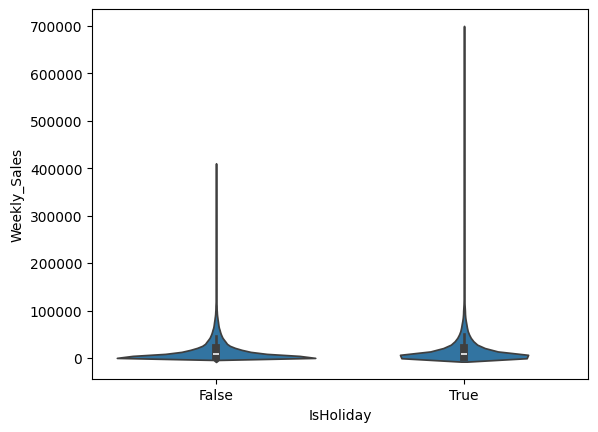

In [42]:
import matplotlib.pyplot as plt

# Separate data
holiday_sales = train.loc[train["IsHoliday"] == True, "Weekly_Sales"]
nonholiday_sales = train.loc[train["IsHoliday"] == False, "Weekly_Sales"]

sns.violinplot(x="IsHoliday", y="Weekly_Sales", data=train)
plt.show()



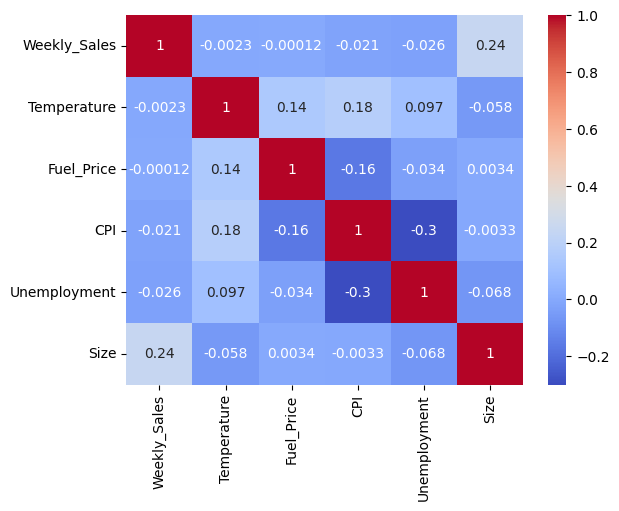

In [9]:
corr = train[["Weekly_Sales", "Temperature", "Fuel_Price", "CPI", "Unemployment", "Size"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()


In [33]:
train["Date"] = pd.to_datetime(train["Date"])
train["WeekOfYear"] = train["Date"].dt.isocalendar().week
train["Month"] = train["Date"].dt.month
train["Year"] = train["Date"].dt.year


In [34]:
train.sort_values(["Store", "Dept", "Date"], inplace=True)
train["Prev_Week_Sales"] = train.groupby(["Store", "Dept"])["Weekly_Sales"].shift(1)
train["Rolling_Mean_4"] = train.groupby(["Store", "Dept"])["Weekly_Sales"].transform(lambda x: x.shift(1).rolling(4).mean())


In [37]:
if "Type" in train.columns:
    train = pd.get_dummies(train, columns=["Type"], drop_first=True)


In [38]:
train["Prev_Week_Sales"] = train["Prev_Week_Sales"].fillna(0)
train["Rolling_Mean_4"] = train["Rolling_Mean_4"].fillna(0)



In [39]:
train = train.sort_values("Date")

# Separate target
X = train.drop(columns=["Weekly_Sales", "Date"])
y = train["Weekly_Sales"]

# Simple holdout split
split_date = "2012-05-01"
X_train = X[train["Date"] < split_date]
y_train = y[train["Date"] < split_date]

X_test = X[train["Date"] >= split_date]
y_test = y[train["Date"] >= split_date]


In [40]:
rf = RandomForestRegressor(n_estimators=100, random_state=42,max_depth=10, n_jobs=4)
rf.fit(X_train, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [43]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)


RMSE: 31055.627548076034
MAE: 19841.672168604127
R²: -0.9866720996287905


     Actual     Predicted
0    242.01    148.334597
1   1855.68   2766.489503
2   1116.04   1371.806773
3    536.37    771.809605
4  33427.25  35161.910018


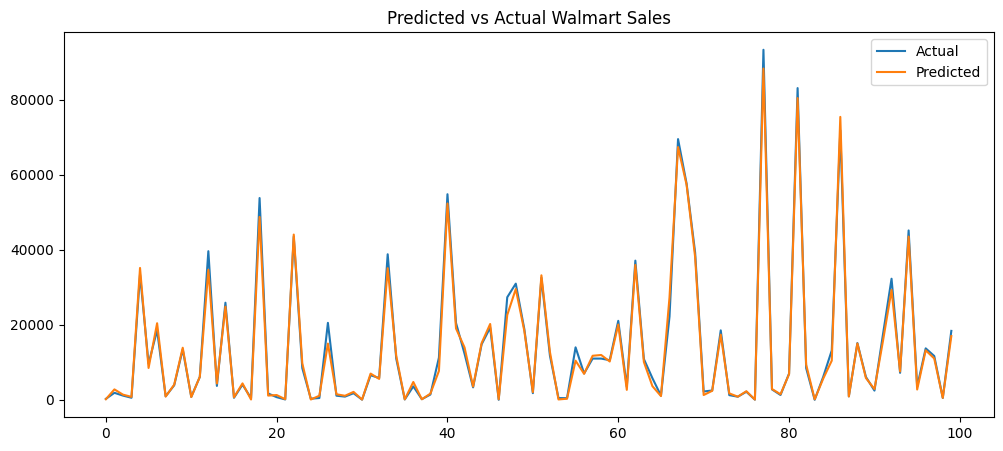

In [31]:
# Predict
y_pred = rf.predict(X_test)

# Put into DataFrame
results = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred
})

# Show first rows
print(results.head())

# Plot
plt.figure(figsize=(12,5))
plt.plot(results["Actual"].values[:100], label="Actual")
plt.plot(results["Predicted"].values[:100], label="Predicted")
plt.legend()
plt.title("Predicted vs Actual Walmart Sales")
plt.show()


In [45]:
print(stores.head())

# How many stores?
num_stores = stores["Store"].nunique()
print(f"✅ Total unique stores: {num_stores}")

   Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875
✅ Total unique stores: 45


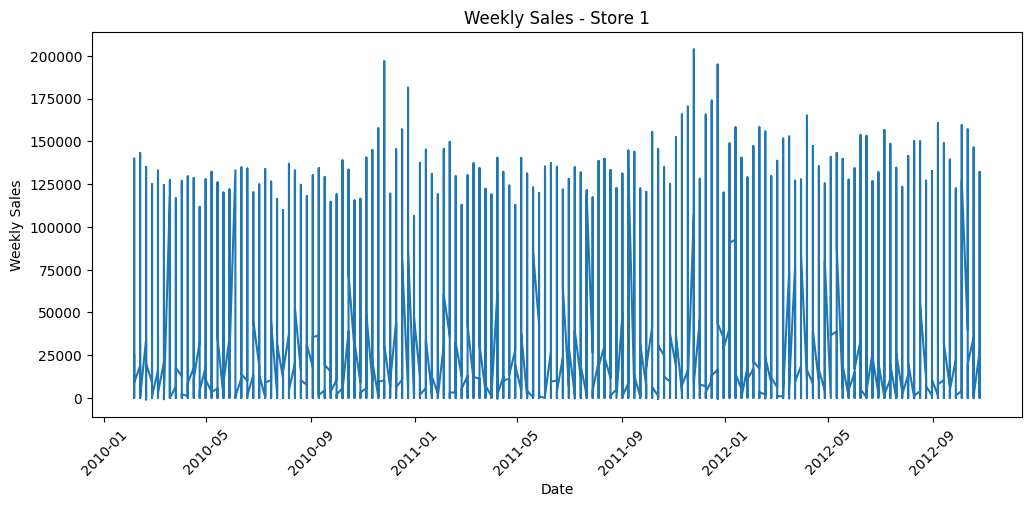

In [46]:
import matplotlib.pyplot as plt

store_id = 1

mask = train["Store"] == store_id

plt.figure(figsize=(12,5))
plt.plot(train.loc[mask, "Date"], train.loc[mask, "Weekly_Sales"])
plt.title(f"Weekly Sales - Store {store_id}")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.xticks(rotation=45)
plt.show()
